# The LSTM
The model we chose to use for our project is the LSTM. The LSTM is a model able to capture long-term dependencies, as the name suggest (Long-Short Term Memory), making it ideal for sequence prediction and, in our case, motion forecasting. \
The principle of the LSTM is to deal with the vanishing / exploding gradient problem of RNNs by saving the long-term memory and the short-term memory into two different states; the long-term memory is saved in the cell state (c_t), while the short-term memory is saved in the hidden state (h_t).
![alt text](LSTM.png)

## The LSTM cell
The LSTM cell is called a "gated structure"; this is beacuse each cell has three gates, called the forget gate, the input gate and the output gate
![alt text](LSTM_Cell.png)

### The forget gate
The forget gate controls how much of the long-term memory we keep by passing the current input through a sigmoid function together with the hidden layer and bias, and then multiplying it by the previous cell state c_t-1. A smaller value means less relevance of the past memory, while a bigger value means more relevance. In other words, the forget gate decides what to delete from the past
![alt text](ForgetGate.png)

### The input gate
The input gate decides how much of the current input and hidden state will influence the future long-term memory; in other words, decides what to add to the memory from the present.
![alt text](InputGate.png)

### The output gate
The output gate takes the updated cell state (C_t), applies a tanh⁡ function to scale its values between −1 and 1, and then multiplies this by o_t (the output gate's activation vector). This produces the hidden state. The hidden state (h_t) represents the short-term memory that is immediately relevant for making predictions or decisions at the current time step. \
In other words, the output gate decides how much of the current memory should be shared as hidden state.
![alt text](OutputGate.png)

# The model

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
import math
import wandb
import os

In [50]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz

        # Projection layer to adjust input to hidden size to handle any input size
        self.input_projection = nn.Linear(input_sz, hidden_sz)

        self.W = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4)) # Input weights: [U_i, U_o, U_c, U_f]
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4)) # Hidden state weights: [W_i, W_o, W_c, W_f]
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4)) # Biases: [b_i, b_o, b_c, b_f]
        self.init_weights()

        # FUlly connected layer to original input size for making predictions 
        self.fc = nn.Linear(hidden_sz, input_sz)

    def forward(self, x, init_states=None):
        bs, seq_sz, input_features = x.size() # Unpack x to batch size, sequence size (time steps), input features

        # Project input to hidden size
        x_projected = self.input_projection(x)

        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size 
        for t in range(seq_sz): # For each time step t:
            x_t = x_projected[:, t, :] # We take the curret input
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))

        # Use the last hidden state for prediction
        prediction = self.fc(h_t)

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return prediction, (h_t, c_t)

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

# Training and validation loop

In [51]:
wandb.init(
    # set the wandb project where this run will be logged
    project="AMPM",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.005,
    "architecture": "LSTM",
    "dataset": "Self-collected, dataset6",
    "epochs": 200,
    "hidden_size": 64,
    "normalization": "Standardized",
    "batch_size": 32
    }
)

In [52]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Merge `num_windows` with `batch_size`
            bs, nw, seq_len, feature_dim = X_batch.shape
            # print("X_batch shape before merging: ", X_batch.shape)
            X_batch = X_batch.view(bs * nw, seq_len, feature_dim)
            # print("X_batch shape after merging: ", X_batch.shape)

            # Adjust y_batch accordingly
            y_batch = y_batch.view(bs * nw, -1)

            # Pass reshaped inputs to the model
            output, _ = model(X_batch)

            # Compute the loss
            loss = criterion(output, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        wandb.log({"Train loss": train_loss})
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
               
                bs, nw, seq_len, feature_dim = X_batch.shape
                X_batch = X_batch.view(bs * nw, seq_len, feature_dim)

                y_batch = y_batch.view(bs * nw, -1)

                output, _ = model(X_batch)
               
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Apply scheduler step to reduce learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        wandb.log({"Val loss": val_loss})

    return train_losses, val_losses

# Loading data and Custom Dataset class

In [53]:
def load_data(data_path):
    data = torch.load(data_path, weights_only=True)
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']
    X_test, y_test = data['X_test'], data['y_test']

    return X_train, y_train, X_val, y_val, X_test, y_test

In [54]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Let's look at the data

In [55]:
import pandas as pd
import numpy as np

In [56]:
data_path = 'lstm_dataset6.pt'
X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

## X_train and y_train
X_train and y_train each contain 41 elements, which are the number of movements recorded.

In [57]:
print("Number of movements inside X_train:", len(X_train))
print("Number of movements inside y_train:", len(y_train))

Number of movements inside X_train: 41
Number of movements inside y_train: 41


Each of this movement is then split upon 40 further time series, each time series being 10 time steps and 8 features in case of X_train and only one time step in case of y_train

In [58]:
print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train[0].shape) 

X_train shape: torch.Size([40, 10, 8])
y_train shape: torch.Size([40, 8])


### Single movement

In [59]:
single_x_tensor = X_train[0][0]
print("\nSingle X_train tensor:")
print(single_x_tensor)

single_y_tensor = y_train[0][0]
print("\nCorresponding y_train tensor:")
print(single_y_tensor)


Single X_train tensor:
tensor([[-0.0402, -0.3652,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [-0.0290, -0.3652,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.0066, -0.3655,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825,  0.0123],
        [ 0.0480, -0.3656,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0481],
        [ 0.0895, -0.3652,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.1310, -0.3650,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.1724, -0.3649,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.2139, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.2554, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.2969, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238]])

Corresponding y_train tensor:
tensor([ 0.3383, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238])


In [60]:
columns = ['x', 'y', 'z', 'roll', 'pitch', 'yaw', 'linear_velocity', 'angular_velocity']

single_x_np = single_x_tensor.numpy()
single_y_np = single_y_tensor.numpy()

df_x = pd.DataFrame(single_x_np, columns=columns)

df_y = pd.DataFrame([single_y_np], columns=columns)

print("X_train tensor as table:")
print(df_x)
print("\ny_train tensor as table:")
print(df_y)

X_train tensor as table:
          x         y    z  roll  pitch       yaw  linear_velocity  \
0 -0.040197 -0.365190  0.0   0.0    0.0  0.153439         1.082531   
1 -0.028958 -0.365195  0.0   0.0    0.0  0.153439         1.082531   
2  0.006575 -0.365532  0.0   0.0    0.0  0.153439         1.082531   
3  0.048038 -0.365624  0.0   0.0    0.0  0.153439         1.082531   
4  0.089508 -0.365212  0.0   0.0    0.0  0.153439         1.082531   
5  0.130979 -0.365017  0.0   0.0    0.0  0.153439         1.082531   
6  0.172448 -0.364908  0.0   0.0    0.0  0.153439         1.082531   
7  0.213917 -0.364838  0.0   0.0    0.0  0.153439         1.082531   
8  0.255389 -0.364792  0.0   0.0    0.0  0.153439         1.082531   
9  0.296858 -0.364766  0.0   0.0    0.0  0.153439         1.082531   

   angular_velocity  
0         -0.023835  
1         -0.023835  
2          0.012337  
3         -0.048119  
4         -0.023835  
5         -0.023835  
6         -0.023835  
7         -0.023835  
8     

## X/y_val, X/y_test
The valuation and test data are done similary, with the only difference to be 6 movements for valuation and 6 movements for test. Therefore we have a data split of 77%-11%-11%

In [61]:
print("Number of movements inside X_val:", len(X_val))
print("Number of movements inside y_val:", len(y_val))
print("X_val shape:", X_val[0].shape)
print("y_val shape:", y_val[0].shape)
print("Number of movements inside X_test:", len(X_test))
print("Number of movements inside y_test:", len(y_test))
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test[0].shape)

Number of movements inside X_val: 6
Number of movements inside y_val: 6
X_val shape: torch.Size([40, 10, 8])
y_val shape: torch.Size([40, 8])
Number of movements inside X_test: 6
Number of movements inside y_test: 6
X_test shape: torch.Size([40, 10, 8])
y_test shape: torch.Size([40, 8])


# Training the model

In [62]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomLSTM(input_sz=8, hidden_sz=64).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.00000000001, verbose=True)

    data_path = 'lstm_dataset6.pt'

    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    #test_dataset = CustomDataset(X_test, y_test)

    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=110)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    OUTPUT_DIR = '/home/samuele/MLproject'

    model_name = os.path.join(OUTPUT_DIR, 'AMPM_2' + '.ptm')
    torch.save(model.state_dict(), model_name)
    print('Model saved as: ' + model_name)

/home/samuele/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/110, Train Loss: 0.5104, Val Loss: 0.4962
Epoch 2/110, Train Loss: 0.5053, Val Loss: 0.4276
Epoch 3/110, Train Loss: 0.4323, Val Loss: 0.3530
Epoch 4/110, Train Loss: 0.3495, Val Loss: 0.3067
Epoch 5/110, Train Loss: 0.2319, Val Loss: 0.2819
Epoch 6/110, Train Loss: 0.1879, Val Loss: 0.2488
Epoch 7/110, Train Loss: 0.2021, Val Loss: 0.2165
Epoch 8/110, Train Loss: 0.1493, Val Loss: 0.1873
Epoch 9/110, Train Loss: 0.1480, Val Loss: 0.1714
Epoch 10/110, Train Loss: 0.1336, Val Loss: 0.1593
Epoch 11/110, Train Loss: 0.1298, Val Loss: 0.1483
Epoch 12/110, Train Loss: 0.1241, Val Loss: 0.1426
Epoch 13/110, Train Loss: 0.1495, Val Loss: 0.1415
Epoch 14/110, Train Loss: 0.1359, Val Loss: 0.1412
Epoch 15/110, Train Loss: 0.1323, Val Loss: 0.1423
Epoch 16/110, Train Loss: 0.1011, Val Loss: 0.1426
Epoch 17/110, Train Loss: 0.1059, Val Loss: 0.1400
Epoch 18/110, Train Loss: 0.0730, Val Loss: 0.1353
Epoch 19/110, Train Loss: 0.0912, Val Loss: 0.1313
Epoch 20/110, Train Loss: 0.0822, Val Lo

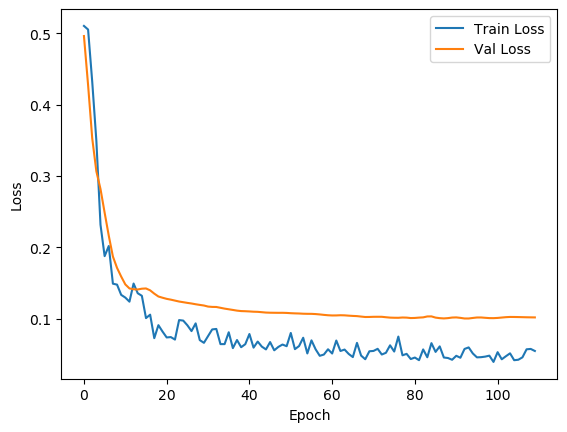

Model saved as: /home/samuele/MLproject/AMPM_2.ptm


In [63]:
if __name__ == '__main__':
    main()

# Using the model for predictions

In [64]:
import json

In [65]:
def test_model(model, test_loader, criterion, device, feature_count=8):
    model.eval() 
    test_loss = 0.0
    all_y_truth = []
    all_y_pred = []

    with torch.no_grad():  
        for X_batch, y_batch in test_loader:
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            bs, nw, seq_len, feature_dim = X_batch.shape
            X_batch = X_batch.view(bs * nw, seq_len, feature_dim)
            y_batch = y_batch.view(bs * nw, -1)

            y_pred, _ = model(X_batch)

            # Reshape predictions and ground truth to original shape for comparison
            y_pred = y_pred.view(bs, nw, -1)
            y_batch = y_batch.view(bs, nw, -1)

            loss = criterion(y_pred[:, :, :feature_count], y_batch[:, :, :feature_count])
            test_loss += loss.item()

            all_y_truth.append(y_batch[:, :, :feature_count].cpu())
            all_y_pred.append(y_pred[:, :, :feature_count].cpu())

    avg_test_loss = test_loss / len(test_loader)

    # Convert predictions and truth to a format suitable for json
    all_y_truth = torch.cat(all_y_truth, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    print(f"Test Loss: {avg_test_loss:.4f}")

    save_results_as_json(all_y_truth, all_y_pred)

In [66]:
def save_results_as_json(truths, predictions, output_path="results.json"):
    results = []
    movement_id = 1
    for truth, pred in zip(truths, predictions):
        for t_row, p_row in zip(truth, pred):
            differences = [round(float(t) - float(p), 2) for t, p in zip(t_row.tolist(), p_row.tolist())]
            results.append({
                "Movement": movement_id,
                "Ground Truth": [f"{val:+.2f}" for val in t_row.tolist()],
                "Prediction": [f"{val:+.2f}" for val in p_row.tolist()],
                "Difference": [f"{val:+.2f}" for val in differences]
            })
            movement_id += 1

    with open(output_path, 'w') as json_file:
        json.dump(results, json_file, indent=4)
    print(f"Results saved to {output_path}")

In [67]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomLSTM(input_sz=8, hidden_sz=64).to(device)

    model_path = 'AMPM_2.ptm'
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

    criterion = nn.MSELoss()

    data_path = 'lstm_dataset6.pt'
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    test_dataset = CustomDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    test_model(model, test_loader, criterion, device, feature_count=8)

In [68]:
if __name__ == '__main__':
    main()

Test Loss: 0.0593
Results saved to results.json
